# `DataFrame` objects
A DataFrame object represents a spreadsheet, with cell values, column names and row index labels. You can define expressions to compute columns based on other columns, create pivot-tables, group rows, draw graphs, etc. You can see `DataFrame`s as dictionaries of `Series`.

## Creating a `DataFrame`
You can create a DataFrame by passing a dictionary of `Series` objects:

In [109]:
import pandas as pd
import numpy as np

In [89]:
people_dict = {
    "weight": pd.Series([68, 83, 112], index=["alice", "bob", "charles"]),
    "birthyear": pd.Series([1984, 1985, 1992], index=["bob", "alice", "charles"], name="year"),
    "children": pd.Series([0, 3], index=["charles", "bob"]),
    "hobby": pd.Series(["Biking", "Dancing"], index=["alice", "bob"]),
}
people = pd.DataFrame(people_dict)
people

,weight,birthyear,children,hobby
alice,68,1985,NaN,Biking
bob,83,1984,3.0,Dancing
charles,112,1992,0.0,NaN


A few things to note:
* the `Series` were automatically aligned based on their index,
* missing values are represented as `NaN`,
* `Series` names are ignored (the name `"year"` was dropped),


You can access columns pretty much as you would expect. They are returned as `Series` objects:

In [15]:
people["birthyear"]

alice      1985
bob        1984
charles    1992
Name: birthyear, dtype: int64

You can also get multiple columns at once:

In [16]:
people[["birthyear", "hobby"]]

,birthyear,hobby
alice,1985,Biking
bob,1984,Dancing
charles,1992,NaN


If you pass a list of columns and/or index row labels to the `DataFrame` constructor, it will guarantee that these columns and/or rows will exist, in that order, and no other column/row will exist. For example:

In [17]:
d2 = pd.DataFrame(
        people_dict,
        columns=["birthyear", "weight", "height"],
        index=["bob", "alice", "eugene"]
     )
d2

,birthyear,weight,height
bob,1984.0,83.0,NaN
alice,1985.0,68.0,NaN
eugene,NaN,NaN,NaN


Another convenient way to create a `DataFrame` is to pass all the values to the constructor as an `ndarray`, or a list of lists, and specify the column names and row index labels separately:

In [18]:
values = [
            [1985, np.nan, "Biking",   68],
            [1984, 3,      "Dancing",  83],
            [1992, 0,      np.nan,    112]
         ]
d3 = pd.DataFrame(
        data= values,
        columns=["birthyear", "children", "hobby", "weight"],
        index=["alice", "bob", "charles"]
     )
d3

,birthyear,children,hobby,weight
alice,1985,NaN,Biking,68
bob,1984,3.0,Dancing,83
charles,1992,0.0,NaN,112


To specify missing values, you can either use `np.nan` or NumPy's masked arrays:

In [20]:
masked_array = np.ma.asarray(values, dtype=np.object)
masked_array

masked_array(
  data=[[1985, nan, 'Biking', 68],
        [1984, 3, 'Dancing', 83],
        [1992, 0, nan, 112]],
  mask=False,
  fill_value='?',
  dtype=object)

In [21]:
masked_array = np.ma.asarray(values, dtype=np.object)
masked_array[(0, 2), (1, 2)] = np.ma.masked
d3 = pd.DataFrame(
        masked_array,
        columns=["birthyear", "children", "hobby", "weight"],
        index=["alice", "bob", "charles"]
     )
d3

,birthyear,children,hobby,weight
alice,1985,NaN,Biking,68
bob,1984,3,Dancing,83
charles,1992,0,NaN,112


Instead of an `ndarray`, you can also pass a `DataFrame` object:

In [22]:
d4 = pd.DataFrame(
         d3,
         columns=["hobby", "children"],
         index=["alice", "bob"]
     )
d4

,hobby,children
alice,Biking,NaN
bob,Dancing,3


It is also possible to create a `DataFrame` with a dictionary (or list) of dictionaries (or list):

In [ ]:
people = pd.DataFrame({
    "birthyear": {"alice":1985, "bob": 1984, "charles": 1992},
    "hobby": {"alice":"Biking", "bob": "Dancing"},
    "weight": {"alice":68, "bob": 83, "charles": 112},
    "children": {"bob": 3, "charles": 0}
})
people

## Multi-indexing
If all columns are tuples of the same size, then they are understood as a multi-index. The same goes for row index labels. For example:

In [39]:
d5 = pd.DataFrame(
  {
    ("public", "birthyear"):
        {("Paris","alice"):1985, ("Paris","bob"): 1984, ("London","charles"): 1992},
    ("public", "hobby"):
        {("Paris","alice"):"Biking", ("Paris","bob"): "Dancing"},
    ("private", "weight"):
        {("Paris","alice"):68, ("Paris","bob"): 83, ("London","charles"): 112},
    ("private", "children"):
        {("Paris", "alice"):np.nan, ("Paris","bob"): 3, ("London","charles"): 0}
  }
)
d5

public          private         
               birthyear    hobby  weight children
London charles      1992      NaN     112      0.0
Paris  alice        1985   Biking      68      NaN
       bob          1984  Dancing      83      3.0

You can now get a `DataFrame` containing all the `"public"` columns very simply:

In [24]:
d5["public"]

birthyear    hobby
London charles       1992      NaN
Paris  alice         1985   Biking
       bob           1984  Dancing

In [25]:
d5["public", "hobby"]  # Same result as d5["public"]["hobby"]

London  charles        NaN
Paris   alice       Biking
        bob        Dancing
Name: (public, hobby), dtype: object

## Dropping a level
Let's look at `d5` again:

In [40]:
d5

public          private         
               birthyear    hobby  weight children
London charles      1992      NaN     112      0.0
Paris  alice        1985   Biking      68      NaN
       bob          1984  Dancing      83      3.0

There are two levels of columns, and two levels of indices. We can drop a column level by calling `droplevel()` (the same goes for indices):

In [44]:
#d5.columns = d5.columns.droplevel(level = 0,)
#d5.index = d5.index.droplevel(level=0)
d5

,birthyear,hobby,weight,children
charles,1992,NaN,112,0.0
alice,1985,Biking,68,NaN
bob,1984,Dancing,83,3.0


## Transposing
You can swap columns and indices using the `T` attribute:

In [45]:
d6 = d5.T
d6

,charles,alice,bob
birthyear,1992,1985,1984
hobby,NaN,Biking,Dancing
weight,112,68,83
children,0,NaN,3


## Stacking and unstacking levels
Calling the `stack()` method will push the lowest column level after the lowest index:

In [46]:
d7 = d6.stack()
d7

birthyear  charles       1992
           alice         1985
           bob           1984
hobby      alice       Biking
           bob        Dancing
weight     charles        112
           alice           68
           bob             83
children   charles          0
           bob              3
dtype: object

Note that many `NaN` values appeared. This makes sense because many new combinations did not exist before (eg. there was no `bob` in `London`).

Calling `unstack()` will do the reverse, once again creating many `NaN` values.

In [ ]:
d8 = d7.unstack()
d8

If we call `unstack` again, we end up with a `Series` object:

In [ ]:
d9 = d8.unstack()
d9

The `stack()` and `unstack()` methods let you select the `level` to stack/unstack. You can even stack/unstack multiple levels at once:

In [ ]:
d10 = d9.unstack(level = (0,1))
d10

## Most methods return modified copies
As you may have noticed, the `stack()` and `unstack()` methods do not modify the object they apply to. Instead, they work on a copy and return that copy. This is true of most methods in pandas.

## Accessing rows
Let's go back to the `people` `DataFrame`:
- see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [47]:
people

,weight,birthyear,children,hobby
alice,68,1985,NaN,Biking
bob,83,1984,3.0,Dancing
charles,112,1992,0.0,NaN


The `loc` attribute lets you access rows instead of columns. The result is a `Series` object in which the `DataFrame`'s column names are mapped to row index labels:

In [51]:
people.loc["charles"]

weight        112
birthyear    1992
children        0
hobby         NaN
Name: charles, dtype: object

You can also access rows by integer location using the `iloc` attribute:

In [49]:
people.iloc[2]

weight        112
birthyear    1992
children        0
hobby         NaN
Name: charles, dtype: object

You can also get a slice of rows, and this returns a `DataFrame` object:

In [ ]:
people.iloc[1:3]

Finally, you can pass a boolean array to get the matching rows:

In [52]:
people[np.array([True, False, True])]

,weight,birthyear,children,hobby
alice,68,1985,NaN,Biking
charles,112,1992,0.0,NaN


This is most useful when combined with boolean expressions:

In [55]:
people["birthyear"] < 1990

alice       True
bob         True
charles    False
Name: birthyear, dtype: bool

In [56]:
people[people["birthyear"] < 1990] ="DNA"

In [ ]:
people

In [74]:
dates = pd.date_range('1/1/2000', periods=8)
df = pd.DataFrame(np.random.randn(8, 4), index=dates, columns=['A', 'B', 'C', 'D'])
df

,A,B,C,D
2000-01-01,0.837054,0.186521,-1.781242,-0.436831
2000-01-02,1.391582,0.926632,-0.005027,-0.167154
2000-01-03,0.534584,0.403096,1.691480,1.285563
2000-01-04,-0.897861,-0.852450,-1.009562,0.345817
2000-01-05,-0.106669,-0.219265,0.264447,-0.813590
2000-01-06,1.200088,-1.505858,-0.757073,1.339314
2000-01-07,0.330080,0.509572,0.107080,0.515510
2000-01-08,-1.459201,1.861112,-1.244583,-0.337015


In [69]:
# Here a system view so we change the data
s = df['A']
s[dates[5]] = 999
df

,A,B,C,D
2000-01-01,0.105862,-0.270689,-2.620326,-1.470089
2000-01-02,-0.370032,0.882980,-1.410122,0.069963
2000-01-03,0.248201,0.775831,0.474029,-1.001253
2000-01-04,0.156990,0.476297,-0.377153,-2.125986
2000-01-05,2.054006,0.644836,-0.443229,0.619113
2000-01-06,999.000000,0.897445,-0.234176,0.963820
2000-01-07,1.710447,0.365435,0.083282,-1.246136
2000-01-08,1.357730,-1.593662,-0.587997,0.905742


In [64]:
# data are modified
df[['B', 'A']] = df[['A', 'B']]
df

,A,B,C,D
2000-01-01,-0.025259,1.216838,-1.538118,-0.313580
2000-01-02,1.437790,-0.025119,-0.926692,1.788179
2000-01-03,0.203057,0.096227,1.837098,-1.637048
2000-01-04,0.120018,0.496111,1.122097,0.353093
2000-01-05,-0.562917,3.173622,1.602916,1.397638
2000-01-06,999.000000,0.272213,0.939760,0.120192
2000-01-07,-0.380246,-0.442584,0.677188,1.164197
2000-01-08,0.944950,-0.751313,-0.823858,-1.378449


### ** but here no modification because there : pandas aligns all AXES when setting Series and DataFrame from .loc, and .iloc.**

In [78]:
df.loc[:, ['B', 'A']] = df[['A', 'B']]
pd.__version__

'0.23.0'

In [81]:
#use his
#df.loc[:, ['B', 'A']] = df[['A', 'B']].to_numpy() # only for 0.24 numpy version
df.loc[:, ['B', 'A']] = df[['A', 'B']].values
df

,A,B,C,D
2000-01-01,0.186521,0.837054,-1.781242,-0.436831
2000-01-02,0.926632,1.391582,-0.005027,-0.167154
2000-01-03,0.403096,0.534584,1.691480,1.285563
2000-01-04,-0.852450,-0.897861,-1.009562,0.345817
2000-01-05,-0.219265,-0.106669,0.264447,-0.813590
2000-01-06,-1.505858,1.200088,-0.757073,1.339314
2000-01-07,0.509572,0.330080,0.107080,0.515510
2000-01-08,1.861112,-1.459201,-1.244583,-0.337015


In [ ]:
df[['A', 'B']] = df.loc[:, ['B', 'A']] 
df

## Adding and removing columns
You can generally treat `DataFrame` objects like dictionaries of `Series`, so the following work fine:

In [83]:
people

,weight,birthyear,children,hobby
alice,DNA,DNA,DNA,DNA
bob,DNA,DNA,DNA,DNA
charles,112,1992,0,NaN


In [90]:
people["age"] = 2018 - people["birthyear"]  # adds a new column "age"
people["over 30"] = people["age"] > 30      # adds another column "over 30"
birthyears = people.pop("birthyear")
del people["children"]

people

,weight,hobby,age,over 30
alice,68,Biking,33,True
bob,83,Dancing,34,True
charles,112,NaN,26,False


In [91]:
birthyears

alice      1985
bob        1984
charles    1992
Name: birthyear, dtype: int64

When you add a new colum, it must have the same number of rows. Missing rows are filled with NaN, and extra rows are ignored:

In [92]:
people["pets"] = pd.Series({"bob": 0, "charles": 5, "eugene":1})  # alice is missing, eugene is ignored
people

,weight,hobby,age,over 30,pets
alice,68,Biking,33,True,NaN
bob,83,Dancing,34,True,0.0
charles,112,NaN,26,False,5.0


When adding a new column, it is added at the end (on the right) by default. You can also insert a column anywhere else using the `insert()` method:

In [93]:
people.insert(1, "height", [172, 181, 185])
people

,weight,height,hobby,age,over 30,pets
alice,68,172,Biking,33,True,NaN
bob,83,181,Dancing,34,True,0.0
charles,112,185,NaN,26,False,5.0


## Assigning new columns
You can also create new columns by calling the `assign()` method. Note that this returns a new `DataFrame` object, the original is not modified:

In [94]:
people.assign(
    body_mass_index = people["weight"] / (people["height"] / 100) ** 2,
    has_pets = people["pets"] > 0
)

,weight,height,hobby,age,over 30,pets,body_mass_index,has_pets
alice,68,172,Biking,33,True,NaN,22.985398,False
bob,83,181,Dancing,34,True,0.0,25.335002,False
charles,112,185,NaN,26,False,5.0,32.724617,True


Note that you cannot access columns created within the same assignment:

In [ ]:
try:
    people.assign(
        body_mass_index = people["weight"] / (people["height"] / 100) ** 2,
        overweight = people["body_mass_index"] > 25
    )
except KeyError as e:
    print("Key error:", e)

The solution is to split this assignment in two consecutive assignments:

In [ ]:
d6 = people.assign(body_mass_index = people["weight"] / (people["height"] / 100) ** 2)
d6.assign(overweight = d6["body_mass_index"] > 25)

Having to create a temporary variable `d6` is not very convenient. You may want to just chain the assigment calls, but it does not work because the `people` object is not actually modified by the first assignment:

In [ ]:
try:
    (people
         .assign(body_mass_index = people["weight"] / (people["height"] / 100) ** 2)
         .assign(overweight = people["body_mass_index"] > 25)
    )
except KeyError as e:
    print("Key error:", e)

But fear not, there is a simple solution. You can pass a function to the `assign()` method (typically a `lambda` function), and this function will be called with the `DataFrame` as a parameter:

In [ ]:
(people
     .assign(body_mass_index = lambda df: df["weight"] / (df["height"] / 100) ** 2)
     .assign(overweight = lambda df: df["body_mass_index"] > 25)
)

Problem solved!

## Evaluating an expression
A great feature supported by pandas is expression evaluation. This relies on the `numexpr` library which must be installed.

In [96]:
people

,weight,height,hobby,age,over 30,pets
alice,68,172,Biking,33,True,NaN
bob,83,181,Dancing,34,True,0.0
charles,112,185,NaN,26,False,5.0


In [101]:
people.eval("B = weight / (height/100) ** 2 > 25",inplace=True)
people

,weight,height,hobby,age,over 30,pets,B
alice,68,172,Biking,33,True,NaN,False
bob,83,181,Dancing,34,True,0.0,True
charles,112,185,NaN,26,False,5.0,True


Assignment expressions are also supported. Let's set `inplace=True` to directly modify the `DataFrame` rather than getting a modified copy:

In [105]:
people.eval("body_mass_index = weight / (height/100) ** 2",inplace=True)
people

,weight,height,hobby,age,over 30,pets,B,body_mass_index
alice,68,172,Biking,33,True,NaN,False,22.985398
bob,83,181,Dancing,34,True,0.0,True,25.335002
charles,112,185,NaN,26,False,5.0,True,32.724617


You can use a local or global variable in an expression by prefixing it with `'@'`:

In [ ]:
overweight_threshold = 30
people.eval("overweight = body_mass_index > @overweight_threshold", inplace=True)
people

## Querying a `DataFrame`
The `query()` method lets you filter a `DataFrame` based on a query expression:

In [ ]:
people.query("age > 30 and pets == 0")

## Sorting a `DataFrame`
You can sort a `DataFrame` by calling its `sort_index` method. By default it sorts the rows by their index label, in ascending order, but let's reverse the order:

In [ ]:
people.sort_index(ascending=False)

Note that `sort_index` returned a sorted *copy* of the `DataFrame`. To modify `people` directly, we can set the `inplace` argument to `True`. Also, we can sort the columns instead of the rows by setting `axis=1`:

In [ ]:
people.sort_index(axis=1, inplace=True)
people

To sort the `DataFrame` by the values instead of the labels, we can use `sort_values` and specify the column to sort by:

In [ ]:
people.sort_values(by="age", inplace=True)
people

## Plotting a `DataFrame`
Just like for `Series`, pandas makes it easy to draw nice graphs based on a `DataFrame`.

For example, it is trivial to create a line plot from a `DataFrame`'s data by calling its `plot` method:

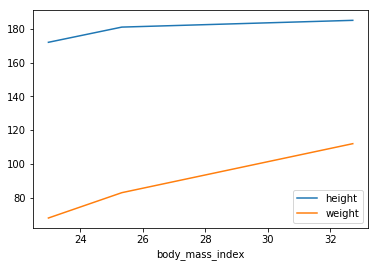

In [107]:
import matplotlib.pyplot as plt
people.plot(kind = "line", x = "body_mass_index", y = ["height", "weight"])
plt.show()

You can pass extra arguments supported by matplotlib's functions. For example, we can create scatterplot and pass it a list of sizes using the `s` argument of matplotlib's `scatter()` function:

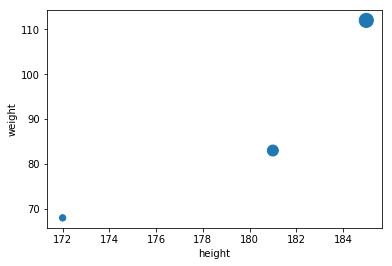

In [110]:
people.plot(kind = "scatter", x = "height", y = "weight", sise=[40, 120, 200])
plt.show()

Again, there are way too many options to list here: the best option is to scroll through the [Visualization](http://pandas.pydata.org/pandas-docs/stable/visualization.html) page in pandas' documentation, find the plot you are interested in and look at the example code.

## Operations on `DataFrame`s
Although `DataFrame`s do not try to mimick NumPy arrays, there are a few similarities. Let's create a `DataFrame` to demonstrate this:

In [113]:
grades_array = np.array([[8,8,9],[10,9,9],[4, 8, 2], [9, 10, 10]])
grades = pd.DataFrame(grades_array, columns=["sep", "oct", "nov"], index=["alice","bob","charles","darwin"])
grades

,sep,oct,nov
alice,8,8,9
bob,10,9,9
charles,4,8,2
darwin,9,10,10


You can apply NumPy mathematical functions on a `DataFrame`: the function is applied to all values:

In [ ]:
np.sqrt(grades)

Similarly, adding a single value to a `DataFrame` will add that value to all elements in the `DataFrame`. This is called *broadcasting*:

In [ ]:
grades + 1

Of course, the same is true for all other binary operations, including arithmetic (`*`,`/`,`**`...) and conditional (`>`, `==`...) operations:

In [ ]:
grades >= 5

Aggregation operations, such as computing the `max`, the `sum` or the `mean` of a `DataFrame`, apply to each column, and you get back a `Series` object:

In [ ]:
grades.mean()

The `all` method is also an aggregation operation: it checks whether all values are `True` or not. Let's see during which months all students got a grade greater than `5`:

In [ ]:
(grades > 5).all()

Most of these functions take an optional `axis` parameter which lets you specify along which axis of the `DataFrame` you want the operation executed. The default is `axis=0`, meaning that the operation is executed vertically (on each column). You can set `axis=1` to execute the operation horizontally (on each row). For example, let's find out which students had all grades greater than `5`:

In [ ]:
(grades > 5).all(axis = 1)

The `any` method returns `True` if any value is True. Let's see who got at least one grade 10:

In [ ]:
(grades == 10).any(axis = 1)

If you add a `Series` object to a `DataFrame` (or execute any other binary operation), pandas attempts to broadcast the operation to all *rows* in the `DataFrame`. This only works if the `Series` has the same size as the `DataFrame`s rows. For example, let's substract the `mean` of the `DataFrame` (a `Series` object) from the `DataFrame`:

In [ ]:
grades - grades.mean()  # equivalent to: grades - [7.75, 8.75, 7.50]

We substracted `7.75` from all September grades, `8.75` from October grades and `7.50` from November grades. It is equivalent to substracting this `DataFrame`:

In [ ]:
pd.DataFrame([[7.75, 8.75, 7.50]]*4, index=grades.index, columns=grades.columns)

If you want to substract the global mean from every grade, here is one way to do it:

In [ ]:
grades - grades.values.mean() # substracts the global mean (8.00) from all grades

## Automatic alignment
Similar to `Series`, when operating on multiple `DataFrame`s, pandas automatically aligns them by row index label, but also by column names. Let's create a `DataFrame` with bonus points for each person from October to December:

In [114]:
grades

,sep,oct,nov
alice,8,8,9
bob,10,9,9
charles,4,8,2
darwin,9,10,10


In [116]:
bonus_array = np.array([[0,np.nan,2],[np.nan,1,0],[0, 1, 0], [3, 3, 0]])
bonus_array

array([[ 0., nan,  2.],
       [nan,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 3.,  3.,  0.]])

In [117]:
bonus_points = pd.DataFrame(bonus_array, columns=["oct", "nov", "dec"], index=["bob","colin", "darwin", "charles"])
bonus_points

,oct,nov,dec
bob,0.0,NaN,2.0
colin,NaN,1.0,0.0
darwin,0.0,1.0,0.0
charles,3.0,3.0,0.0


In [118]:
grades

,sep,oct,nov
alice,8,8,9
bob,10,9,9
charles,4,8,2
darwin,9,10,10


In [119]:
grades + bonus_points

,dec,nov,oct,sep
alice,NaN,NaN,NaN,NaN
bob,NaN,NaN,9.0,NaN
charles,NaN,5.0,11.0,NaN
colin,NaN,NaN,NaN,NaN
darwin,NaN,11.0,10.0,NaN


- For more details: https://stackoverflow.com/questions/51645195/pandas-align-function-illustrative-example/51645550